<a href="https://colab.research.google.com/github/Vani-Kumari/capsuleEndoscopy/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam


In [22]:
# Paths to your training and validation datasets
train_data_dir = '/content/drive/MyDrive/Capsule Endoscopy Dataset/train_dataset'
test_data_dir = '/content/drive/MyDrive/Capsule Endoscopy Dataset/Test_Dataset'


In [23]:
# Parameters
img_height, img_width = 224, 224
batch_size = 32
num_classes = 8
epochs = 50
learning_rate = 1e-4


In [25]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [26]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the model correctly
)

Found 4020 images belonging to 8 classes.
Found 337 images belonging to 8 classes.


In [27]:
# Load ResNet50 pre-trained model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


In [28]:
# Freeze the layers which you don't want to train
for layer in base_model.layers:
    layer.trainable = False


In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [29]:
# Adding custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [30]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [31]:
# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/50
126/126 [==============================] - 2376s 19s/step - loss: 2.1906 - accuracy: 0.1652 - val_loss: 1.9744 - val_accuracy: 0.2107
Epoch 2/50
126/126 [==============================] - 101s 805ms/step - loss: 1.9840 - accuracy: 0.2022 - val_loss: 1.9111 - val_accuracy: 0.2433
Epoch 3/50
126/126 [==============================] - 102s 808ms/step - loss: 1.9475 - accuracy: 0.2050 - val_loss: 1.8896 - val_accuracy: 0.2433
Epoch 4/50
126/126 [==============================] - 103s 821ms/step - loss: 1.9165 - accuracy: 0.2102 - val_loss: 1.8692 - val_accuracy: 0.2463
Epoch 5/50
126/126 [==============================] - 101s 806ms/step - loss: 1.9103 - accuracy: 0.2010 - val_loss: 1.8392 - val_accuracy: 0.2374
Epoch 6/50
126/126 [==============================] - 102s 812ms/step - loss: 1.8831 - accuracy: 0.2204 - val_loss: 1.8063 - val_accuracy: 0.2582
Epoch 7/50
126/126 [==============================] - 100s 790ms/step - loss: 1.8621 - accuracy: 0.2192 - val_loss: 1.7507 - 

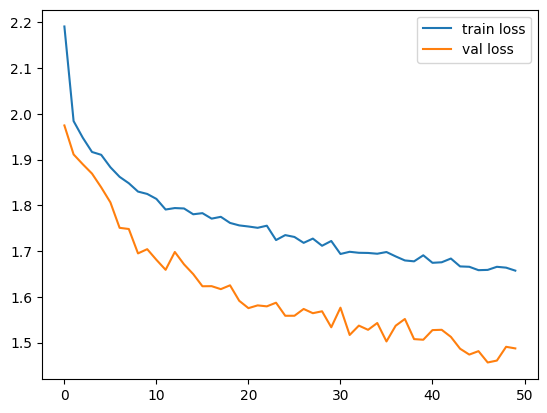

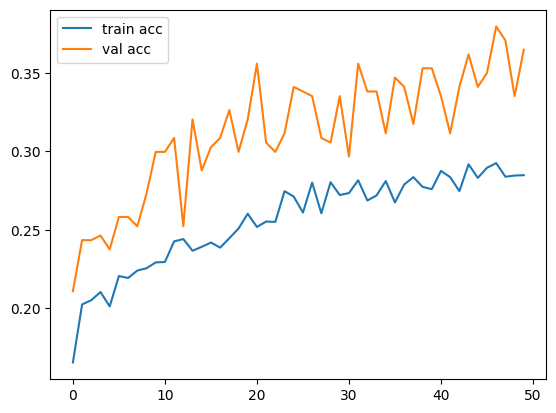

<Figure size 640x480 with 0 Axes>

In [32]:

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [33]:
# Save the model
model.save('capsule_endoscopy_resnet50.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')

11/11 [==============================] - 5s 468ms/step - loss: 1.4873 - accuracy: 0.3650
Test accuracy: 36.50%


In [35]:
# Make predictions on the test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


11/11 [==============================] - 5s 393ms/step


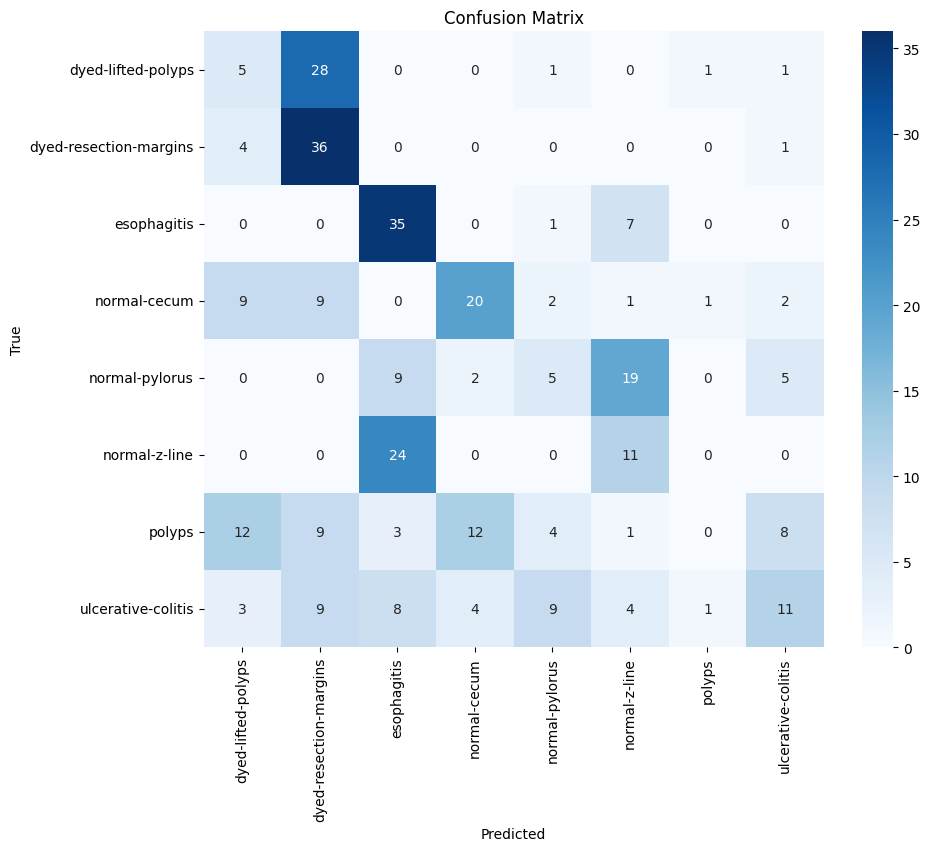

In [36]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
# Compute all classification metrics
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)
support = cm.sum(axis=1)

print(f'Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Support:', support)


Accuracy: 36.50%
Precision: [0.15151515 0.3956044  0.44303797 0.52631579 0.22727273 0.25581395
 0.         0.39285714]
Recall: [0.13888889 0.87804878 0.81395349 0.45454545 0.125      0.31428571
 0.         0.2244898 ]
F1 Score: [0.14492754 0.54545455 0.57377049 0.48780488 0.16129032 0.28205128
 0.         0.28571429]
Support: [36 41 43 44 40 35 49 49]


In [38]:
# Print classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

Classification Report
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.15      0.14      0.14        36
dyed-resection-margins       0.40      0.88      0.55        41
           esophagitis       0.44      0.81      0.57        43
          normal-cecum       0.53      0.45      0.49        44
        normal-pylorus       0.23      0.12      0.16        40
         normal-z-line       0.26      0.31      0.28        35
                polyps       0.00      0.00      0.00        49
    ulcerative-colitis       0.39      0.22      0.29        49

              accuracy                           0.36       337
             macro avg       0.30      0.37      0.31       337
          weighted avg       0.30      0.36      0.31       337

